# Single-Particle Transport (Random Walk)

Single-particle transport can be modeled as a 1-dimensional random walk. Let $x_n$ denote the position of the particle on time step $n$. At each time step, the position moves left with probability $p_-$, moves right with probability $p_+$, or stays the same with probability $p_0$. Let $Z$ be the random variable that describes these probabilistic movements in one time step. That is:

$$x_{n+1} = x_n + Z$$

$$ Z = \{-1,0,1\}~~~\text{, with probabilities }~~~\{p_-,p_0,p_+\} $$

Thus, after $n$ time steps the mean position and variance are given by:

$$ \mu_n = E[nZ] = n(p_+ - p_-) $$

$$ \sigma^2_n = E[n(Z - E[Z])^2] = n \left( E[Z^2] - E[Z]^2 \right) =  n \left( p_+ + p_- - (p_+ - p_-)^2 \right)$$

These statistics either model the expected position and variance of a single particle, or average position and variance of an ensemble of independently transported molecules.

# Bulk Transport (Discretized PDE)

Throughout the paper we model transport using mass-action kinetics. In a cable:

$$\dot{u}_i = au_{i-1} + bu_{i+1} - (a+b)u_i $$

Assume that we have equally-sized compartments of length $\Delta$. Then, with a slight change of notation, we can equivalently write:

$$\dot{u}(x) = \frac{\partial u}{\partial t} = a~u(x-\Delta) + b~u(x+\Delta) - (a+b)~u(x) $$

Using Taylor series expansions for $u(x-\Delta)$ and $u(x+\Delta)$ we arrive at the approximation:

$$
\begin{align}
\frac{\partial u}{\partial t} & \approx a\left[u(x) - \Delta \frac{\partial u}{\partial x} + \frac{\Delta^2}{2} \frac{\partial^2 u}{\partial x^2} \right] + b\left[u(x) + \Delta \frac{\partial u}{\partial x} + \frac{\Delta^2}{2} \frac{\partial^2 u}{\partial x^2} \right] - (a+b)~u(x) \\
 & = a\left[- \Delta \frac{\partial u}{\partial x} + \frac{\Delta^2}{2} \frac{\partial^2 u}{\partial x^2} \right] + b\left[\Delta \frac{\partial u}{\partial x} + \frac{\Delta^2}{2} \frac{\partial^2 u}{\partial x^2} \right]
\end{align}
$$

When we take the limit, $\Delta \rightarrow 0$, this approximation becomes exact, and we arrive at the drift-diffusion equation:

$$
\frac{\partial u}{\partial t} = \underbrace{(b-a)}_{\text{drift coefficient}} \frac{\partial u}{\partial x} + \underbrace{\left(\frac{a+b}{2}\right)}_{\text{diffusion coefficient}} \frac{\partial^2 u}{\partial x^2}
$$

We can derive estimates of $a$ and $b$ from $p_+$ and $p_-$ since the mean is (inversely) proportional to the drift coefficent and the variance is (directly) proportional to the diffusion coefficient:

$$\left\{\begin{matrix}
a - b = \mu \\ 
a + b = \sigma^2
\end{matrix}\right.
\Rightarrow
\left\{\begin{matrix}
a  = \frac{\sigma^2 + \mu}{2} \\ 
b = \frac{\sigma^2 - \mu}{2}
\end{matrix}\right.$$

Plugging in from our above analysis, we find:

$$
a = \frac{2p_+ - (p_+ - p_-)^2}{2}
$$

$$
b = \frac{2p_- - (p_+ - p_-)^2}{2}
$$

In these simulations we choose $p_- = 0.2$, $p_0 = 0.35$ and $p_+ = 0.45$, which gives us $a = $

$$
b = \frac{2p_- - (p_+ - p_-)^2}{2}
$$

In [1]:
from __future__ import division
import pylab as plt
from numpy import random,argwhere,argmax,linspace,logspace,var,mean,tile,dot
from numpy.random import randint
from scipy.optimize import curve_fit
from scipy.stats import norm
import numpy as np
%matplotlib inline

In [2]:
tmax = 120
dt = 1
nt = int(1 + tmax/dt)

velocities = [-1.0, 0.0, 1.0]
klevels = [0.0,0.3,0.4]
pp = np.array([0.20,0.35,0.45])

def get_P(k):
    # parameter k tunes the hysteresis
    # parameter pp are the columns of P when k=0
    P0 = np.tile(pp,(3,1)).T # matrix when k=0
    P1 = np.eye(3)           # matrix when k=1
    return P0*(1-k)+P1*k 

def update(x,s,P,dt):
    # Draw a new state
    s.append(random.choice(range(3),p=P[:,s[-1]]))
    # Determine new velocity
    v = velocities[s[-1]]
    # Append new position
    x.append(x[-1]+v*dt)

In [3]:
def markov_sim(k,n=1,plots=False):
    """
    k = parameter tuning the hysteresis
    n = number of simulations to run (only last sim is returned)
    """
    P = get_P(k) # state transition matrix
    
    for i in range(n):
        x = [0]          # initial position
        s = [random.choice(range(3),p=pp)] # initial state
        t = 0            # initial time
        while t < tmax:
            t += dt
            update(x,s,P,dt)
        if plots: plt.plot(linspace(0,tmax,len(x)),x)
    
    if plots:
        plt.xticks([0,40,80,120])
        plt.yticks([0,50])
        plt.ylim([-5,50])
        plt.xlabel('time',fontsize=15)
        plt.ylabel('position',fontsize=15)
    return x,s

#     plt.subplot(2,1,2)
#     plt.bar(velocities,np.mean(P,axis=1),width=0.1,align='center')
#     plt.ylim([0,0.6])
#     plt.xticks(velocities)
#     plt.xlim([-0.8,0.8])
#     plt.xlabel('velocity',fontsize=15)
#     plt.ylabel('probability',fontsize=15)

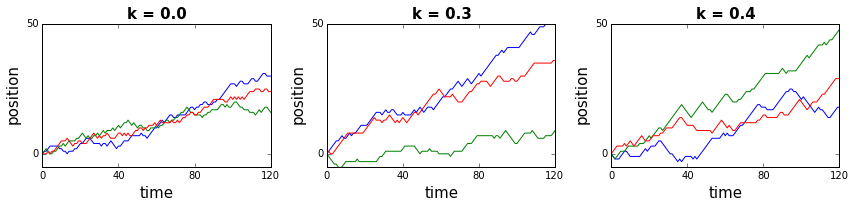

In [4]:
np.random.seed(24403)
plt.figure(figsize=(12,3))
for splt,k in enumerate(klevels):
    plt.subplot(1,3,splt+1)
    markov_sim(k,n=3,plots=True)
    plt.title('k = '+str(k),fontweight='bold',fontsize=15)
plt.tight_layout()
plt.savefig('panelA.svg')
plt.show()

In [5]:
def sim_ensemble(k,N):
    """ N = number of molecules to simulate """
    X = []
    for i in range(N):
        x,s = markov_sim(k,n=1)
        X.append(x)

    X = np.array(X).T        # each column of X is a trajectory
    t = linspace(0,tmax,len(x))  # time axis
    return t,X

def bin_cable(X,nbins):
    d0,d1 = -120.5,120.5          # ends of the cable
    Bx = np.linspace(d0,d1,nbins) # compartment edges
    dx = Bx[1]-Bx[0]              # compartment size
    Bxc = Bx[:-1]+(dx/2)          # compartment centers
    Cx = np.empty((nt,len(Bxc)))  # concentration in each compartment

    for i in range(len(Bxc)):
        Cx[:,i] = np.mean((X > Bx[i]) & (X <= Bx[i+1]),axis=1)
    
    return Cx,Bxc

def plot_conc_profile(data):
    """ Plot the spatial distribution at several time points"""
    tp = np.round(np.linspace(5,tmax,7))#range(10,nt,30)
    cols = np.vstack((np.linspace(0,1,len(tp)),np.zeros(len(tp)),np.linspace(1,0,len(tp))))
    for (c,i) in enumerate(tp):
        plt.plot(Bxc,data[i,:],'-',color=cols[:,c],lw=2)
    plt.yticks([0,0.2])
    plt.ylim([0,0.22])
    plt.xlim([-25,75])
    plt.xlabel('position',fontsize=15)
    plt.ylabel('concentration',fontsize=15)

/Users/alex/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:29: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


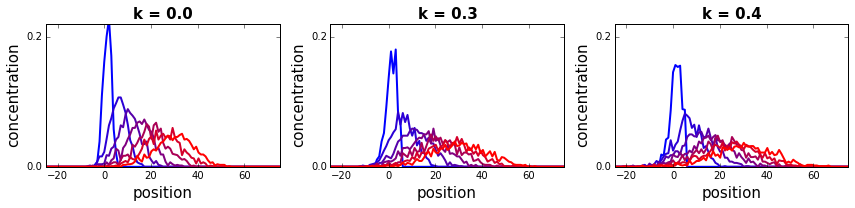

In [6]:
Cx_store = []
var_X = []
mean_X = []
plt.figure(figsize=(12,3))
for splt,k in enumerate(klevels):
    plt.subplot(1,3,splt+1)
    t,X = sim_ensemble(k,1000)
    Cx,Bxc = bin_cable(X,int(tmax)*2)
    Cx_store.append(Cx)
    var_X.append(var(X,axis=1))
    mean_X.append(mean(X,axis=1))
    plot_conc_profile(Cx)
    plt.title('k = '+str(k),fontweight='bold',fontsize=15)
var_X,mean_X = np.array(var_X),np.array(mean_X)
plt.tight_layout()
plt.savefig('panelB.svg')
plt.show()

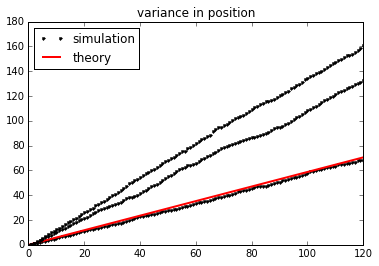

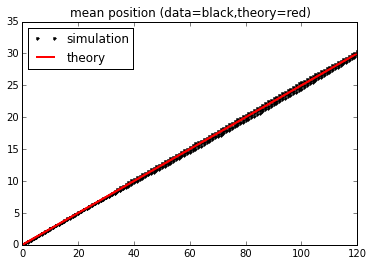

In [7]:
plt.figure()
plt.plot(t,var_X[0,:],'.k')
plt.plot(t,(pp[2]+pp[0]-(pp[2]-pp[0])**2)*t,'-r',lw=2)
for i in range(1,len(klevels)):
    plt.plot(t,var_X[i,:],'.k')
plt.title("variance in position")
plt.legend(('simulation','theory'),loc='best')
plt.figure()
for i in range(len(klevels)):
    plt.plot(t,mean_X[i,:],'.k')
    plt.plot(t,(pp[2]-pp[0])*t,'-r',lw=2)
plt.title("mean position (data=black,theory=red)")
plt.legend(('simulation','theory'),loc='best')
plt.show()

In [8]:
from scipy.linalg import expm

def mass_action_matrix(a_,b_,nC):
    # transport rate constants
    a = np.ones(nC-1)*a_
    b = np.ones(nC-1)*b_

    # construct state-transistion matrix, A
    mid = np.zeros(nC)
    mid[:-1] -= a
    mid[1:]  -= b
    return np.diag(a, -1) + np.diag(mid) + np.diag(b, 1)

def mass_action_simulate(A,nC):
    # initial condition
    u0 = np.zeros(nC)
    u0[(nC-1)/2] = 1.0
    
    # simulate
    u = [u0]   # concentration in each compartment
    eA = expm(A*dt)
    for i in range(nt-1):
        u.append(np.dot(eA,u[-1]))
    return np.array(u)

def f(x,Ctarg,make_plot=False):
    nC = Ctarg.shape[1]
    A = mass_action_matrix(x[0],x[1],nC)
    u = mass_action_simulate(A,nC)
    
    if make_plot:
        print A
        plt.plot(t,u)
        plt.show()
    
    return np.sum((u-Ctarg)**2)

/Users/alex/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:17: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/alex/anaconda/lib/python2.7/site-packages/scipy/stats/_distn_infrastructure.py:1564: RuntimeWarning: divide by zero encountered in true_divide
  x = asarray((x-loc)*1.0/scale)
/Users/alex/anaconda/lib/python2.7/site-packages/scipy/stats/_distn_infrastructure.py:1564: RuntimeWarning: invalid value encountered in true_divide
  x = asarray((x-loc)*1.0/scale)
/Users/alex/anaconda/lib/python2.7/site-packages/scipy/stats/_distn_infrastructure.py:1566: RuntimeWarning: invalid value encountered in greater_equal
  cond1 = (scale > 0) & (x >= self.a) & (x <= self.b)
/Users/alex/anaconda/lib/python2.7/site-packages/scipy/stats/_distn_infrastructure.py:1566: RuntimeWarning: invalid value encountered in less_equal
  cond1 = (scale > 0) & (x >= self.a) & (x <= self.b)
/Users/alex/anaconda/lib/python2.7/site-packag

0.41875 0.16875
0.6787184625 0.425910129167
0.7947914625 0.544733129167


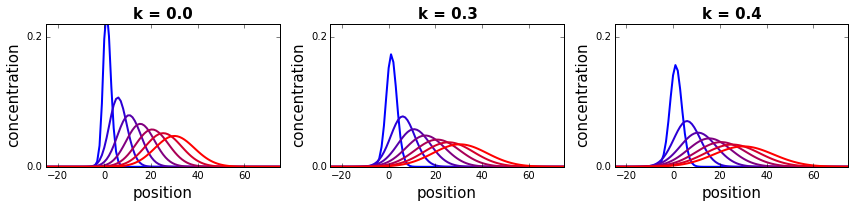

In [9]:
from scipy.optimize import minimize
CxFit_store = []
ab = []
var_dist = [[] for i in range(len(klevels))]
mean_dist = [[] for i in range(len(klevels))]

plt.figure(figsize=(12,3))
for i,Cx in enumerate(Cx_store):
    plt.subplot(1,3,i+1)
    # determine optimal rate constants
    if i == 0:
        # solved analytically
        a_opt = (2*pp[2]-(pp[2]-pp[0])**2)/2 #((3*pp[2]+pp[0])/2) - (pp[2]-pp[0])**2
        b_opt = (2*pp[0]-(pp[2]-pp[0])**2)/2 #((pp[2]+3*pp[0])/2) - (pp[2]-pp[0])**2
        print a_opt,b_opt
    else:
        # choose a and b to fit the mean/variance
        mu = np.mean(np.diff(mean_X[i,:]))
        sig = np.mean(np.diff(var_X[i,:]))
        a_opt = (mu + sig)/2
        b_opt = (-mu + sig)/2
        print a_opt,b_opt
    A = mass_action_matrix(a_opt,b_opt,Cx.shape[1])
    CxFit = mass_action_simulate(A,Cx.shape[1])
    for j in range(CxFit.shape[0]):
        y = CxFit[j,:] # fit a gaussian to the concentration profile
        popt,pcov = curve_fit(norm.pdf,Bxc,y,p0=[Bxc[argmax(y)],j])
        mean_dist[i].append(popt[0])
        var_dist[i].append(popt[1]**2)
    plot_conc_profile(CxFit)
    CxFit_store.append(CxFit)
    ab.append([a_opt,b_opt])
    plt.title('k = '+str(klevels[i]),fontweight='bold',fontsize=15)
plt.tight_layout()
plt.savefig('panelC.svg')
plt.show()

ab = np.array(ab)

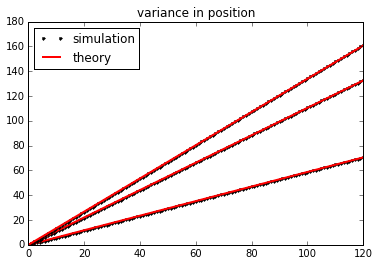

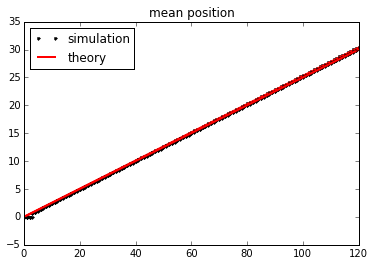

In [10]:
var_dist = np.array(var_dist)
mean_dist = np.array(mean_dist)

plt.figure()
for i in range(3):
    plt.plot(t,var_dist[i,:],'.k')
    plt.plot(t,np.sum(ab[i,:])*t,'-r',lw=2)
plt.title("variance in position")
plt.legend(('simulation','theory'),loc='best')
plt.figure()
for i in range(3):
    plt.plot(t,mean_dist[i,:],'.k')
    plt.plot(t,(ab[i,0]-ab[i,1])*t,'-r',lw=2)
plt.title("mean position")
plt.legend(('simulation','theory'),loc='best')
plt.show()

In [11]:
## Characterize how well the model does as a function of run length and ensemble size
klevels2 = linspace(0,0.9,6)
ensemble_size = np.round(logspace(2,3,4))
nreplicates = 3

error = np.empty((len(klevels2),len(ensemble_size),nreplicates))

for i,k in enumerate(klevels2):
    for j,n in enumerate(ensemble_size):
        for r in range(nreplicates):
            # Simulate an ensemble
            t,X = sim_ensemble(k,int(n))
            Cx,Bxc = bin_cable(X,int(tmax)*2)
            
            # Choose a and b to fit the linear increase in mean/variance
            mu = mean(np.diff(mean(X,axis=1)))
            sig = mean(np.diff(var(X,axis=1)))
            a_opt = (mu + sig)/2
            b_opt = (-mu + sig)/2
            
            # Simulate the mass-action model with fitted parameters
            A = mass_action_matrix(a_opt,b_opt,Cx.shape[1])
            CxFit = mass_action_simulate(A,Cx.shape[1])
            
            error[i,j,r] = np.sum((CxFit - Cx)**2)

/Users/alex/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:17: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


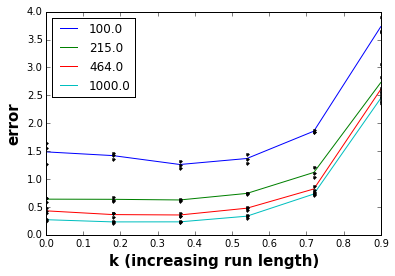

In [12]:
plt.figure()
for i in range(len(ensemble_size)):
    plt.plot(klevels2,mean(error[:,i,:],axis=1),'-')
for i in range(len(ensemble_size)):
    for r in range(nreplicates):
        plt.plot(klevels2,error[:,i,r],'.k')
plt.legend(ensemble_size,loc='best')
plt.xlabel('k (increasing run length)',fontweight='bold',fontsize=15)
plt.ylabel('error',fontweight='bold',fontsize=15)
plt.show()